In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import re

from tqdm import tqdm
import time

import pydicom as dicom
import nibabel as nib
import SimpleITK as sitk
import monai

import torch
import torch.nn as nn
import torch.optim as optim

from monai.networks.nets import EfficientNetBN
from monai.networks.nets import ResNet
#from efficientnet_pytorch import EfficientNet

import wandb


In [2]:
SEED = 344
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))
    
seed_everything(SEED)
print('Training on device {}'.format(device))

Finish seeding with seed 344
Training on device cuda


In [3]:
dicom_tag_columns = [
    'Columns',
    'ImageOrientationPatient',
    'ImagePositionPatient',
    'InstanceNumber',
    'PatientID',
    'PatientPosition',
    'PixelSpacing',
    'RescaleIntercept',
    'RescaleSlope',
    'Rows',
    'SeriesNumber',
    'SliceThickness',
    'path',
    'WindowCenter',
    'WindowWidth'
]

train_dicom_tags = pd.read_parquet('autodl-tmp/train_dicom_tags.parquet', columns=dicom_tag_columns)
test_dicom_tags = pd.read_parquet('autodl-tmp/test_dicom_tags.parquet', columns=dicom_tag_columns)

train_series_meta = pd.read_csv('autodl-tmp/train_series_meta.csv')
test_series_meta = pd.read_csv('autodl-tmp/test_series_meta.csv')

train_csv = pd.read_csv('autodl-tmp/train.csv')

spacing_pd = pd.read_csv('autodl-tmp/spacing.csv')

spacing_pd

,patient_id,series_id,dx,dy,dz
0,10004,21057,0.894531,0.894531,0.5
1,10004,51033,0.951172,0.951172,0.5
2,10005,18667,0.787109,0.787109,5.0
3,10007,47578,0.771484,0.771484,5.0
4,10026,29700,0.585938,0.585938,1.0
...,...,...,...,...,...
4706,9961,2003,0.961000,0.961000,0.8
4707,9961,63032,0.965000,0.965000,0.8
4708,9980,40214,0.890625,0.890625,3.0
4709,9980,40466,0.816406,0.816406,3.0


In [4]:
def raw_path_gen(patient_id, series_id, train=True):
    if(train):
        path = 'autodl-tmp/train_images_resample/'
    else:
        path = 'autodl-tmp/train_images_resample/'
    
    path += str(patient_id) + '/' + str(series_id)
    
    return path

def create_3D_scans(folder, downsample_rate=1): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    #for filename in tqdm(filenames[::downsample_rate], position=0): 
    for filename in filenames[::downsample_rate]: 
        filepath = os.path.join(folder, filename)
        ds = dicom.dcmread(filepath)
        image = ds.pixel_array
        
        if ds.PixelRepresentation == 1:
            bit_shift = ds.BitsAllocated - ds.BitsStored
            dtype = image.dtype 
            image = (image << bit_shift).astype(dtype) >>  bit_shift
        
        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)
    
        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2    
        
        
        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )
    
    volume = np.stack(volume, axis=0)
    return volume

def plot_image_with_seg(volume, volume_seg=[], orientation='Coronal', num_subplots=20):
    # simply copy
    if len(volume_seg) == 0:
        plot_mask = 0
    else:
        plot_mask = 1
        
    if orientation == 'Coronal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([1, 0, 2])
        if plot_mask:
            volume_seg = volume_seg.transpose([1, 0, 2])
        
    elif orientation == 'Sagittal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([2, 0, 1])
        if plot_mask:
            volume_seg = volume_seg.transpose([2, 0, 1])

    elif orientation == 'Axial':
        slices = np.linspace(0, volume.shape[0]-1, num_subplots).astype(np.int16)
           
    rows = np.max( [np.floor(np.sqrt(num_subplots)).astype(int) - 2, 1])
    cols = np.ceil(num_subplots/rows).astype(int)
    
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 2, rows * 4))
    fig.tight_layout(h_pad=0.01, w_pad=0)
    
    ax = ax.ravel()
    for this_ax in ax:
        this_ax.axis('off')

    for counter, this_slice in enumerate( slices ):
        plt.sca(ax[counter])
        
        image = volume[this_slice, :, :]
        plt.imshow(image, cmap='gray')
        
        if plot_mask:
            mask = np.where(volume_seg[this_slice, :, :], volume_seg[this_slice, :, :], np.nan)
            plt.imshow(mask, cmap='Set1', alpha=0.5)
            
def load_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

def load_kidney_left_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'kidney_left.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

def load_kidney_right_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'kidney_right.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

def load_liver_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'liver.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

def load_spleen_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'spleen.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

def load_bowel_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'colon.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'duodenum.nii.gz'
    img = img + sitk.GetArrayFromImage(sitk.ReadImage(path))
    
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'esophagus.nii.gz'
    img = img + sitk.GetArrayFromImage(sitk.ReadImage(path))
    
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'fuse.nii.gz'
    img = img + sitk.GetArrayFromImage(sitk.ReadImage(path))
    
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'small_bowel.nii.gz'
    img = img + sitk.GetArrayFromImage(sitk.ReadImage(path))
    
    path = root + str(patient_id) + '/' + str(series_id) + '/' + 'stomach.nii.gz'
    img = img + sitk.GetArrayFromImage(sitk.ReadImage(path))
    
    img[img > 1] = 1
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

In [5]:
import re

def load_resample(patient_id, series_id, spacing_pd,  root='autodl-tmp/train_images_resample/',
                  target_spacing = (2.0, 2.0, 2.0),
                  target_size = (256, 256, 320)):

    
    dicom_dz = spacing_pd[spacing_pd.series_id == series_id].dz.values[0]

    dicom_spacing_x = spacing_pd[spacing_pd.series_id == series_id].dx.values[0]
    dicom_spacing_y = spacing_pd[spacing_pd.series_id == series_id].dy.values[0]
    
    mask_kidney_left = load_kidney_left_nii(patient_id, series_id, root).astype('int')
    mask_kidney_right = load_kidney_right_nii(patient_id, series_id, root).astype('int')
    mask_liver = load_liver_nii(patient_id, series_id, root).astype('int')
    mask_spleen = load_spleen_nii(patient_id, series_id, root).astype('int')
    mask_bowel = load_bowel_nii(patient_id, series_id, root).astype('int')
    
    original_image = mask_kidney_left + 2*mask_kidney_right + 4*mask_liver + 8*mask_spleen + 16*mask_bowel
    
    original_image = np.flip(original_image, 0)
    original_image = np.flip(original_image, 1)
    original_image = sitk.GetImageFromArray(original_image)
    original_image.SetSpacing((dicom_spacing_x,
                        dicom_spacing_y,
                        dicom_dz))
    

    original_size = original_image.GetSize()
    original_spacing = original_image.GetSpacing()
    
    r_x = dicom_spacing_x / target_spacing[0]
    r_y = dicom_spacing_y / target_spacing[1]
    r_z = dicom_dz / target_spacing[2]
    
    o_x = -(target_size[0] - original_size[0] * r_x)
    o_y = -(target_size[0] - original_size[1] * r_y)
    o_z = -(target_size[2] - original_size[2] * r_z)
    #print((target_size[0] - original_size[0] * r_x) / 2)
    
    
    target_origin = (o_x, o_y, o_z)
    
    
    #print(original_spacing)
    #print(original_size)
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetOutputSpacing(target_spacing)
    resampler.SetSize(target_size)
    resampler.SetOutputOrigin(target_origin)
    resampler.SetDefaultPixelValue(0)
    resampled_image = resampler.Execute(original_image)
    #print(resampled_image.GetSize())
    
    
    return resampled_image

In [6]:


# for idx in tqdm(range(0, len(train_series_meta))):
#     patient_id, series_id = train_series_meta.loc[idx, ["patient_id", "series_id"]].astype('int')
#     mask_img = load_resample(patient_id, series_id, spacing_pd,  root="autodl-tmp/my-total-segmentator/", target_spacing = (2.0, 2.0, 2.0), target_size = (256, 256, 320))
#     save_path = 'autodl-tmp/train_mask/' + str(patient_id) + '/'
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
#     save_path = save_path + str(series_id) + '.nii.gz'
#     sitk.WriteImage(mask_img, save_path)

In [7]:
test_mask = load_resample(9961, 2003, spacing_pd,  root="autodl-tmp/my-total-segmentator/", target_spacing = (2.0, 2.0, 2.0), target_size = (256, 256, 320))

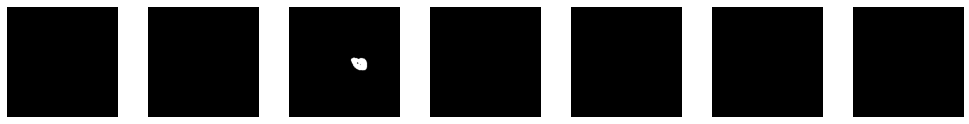

In [34]:
#mask_a = sitk.GetArrayFromImage(test_mask)
patient_id, series_id = train_series_meta.loc[4710, ["patient_id", "series_id"]].astype('int')
mask_a = load_nii(patient_id, series_id, root='autodl-tmp/train_mask/')

mask_kidney_left = mask_a % 2 == 1
mask_kidney_right = (mask_a // 2) % 2 == 1
mask_liver = (mask_a // 4) % 2 == 1
mask_spleen = (mask_a // 8) % 2 == 1
mask_bowel = (mask_a // 16) % 2 == 1
mask_kls = mask_kidney_left + mask_kidney_right + mask_liver + mask_spleen
mask_z = np.sum(np.sum(mask_kls, 1), 1)
middle_z = np.argwhere(mask_z)[len(np.argwhere(mask_z)) // 2][0]

plot_image_with_seg(mask_kidney_left, orientation='Axial', num_subplots=7)

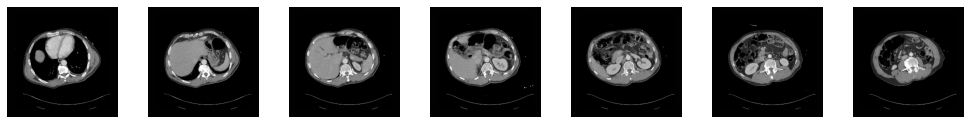

In [36]:
img_a = load_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/')
plot_image_with_seg(img_a[55:155, :, :], orientation='Axial', num_subplots=7)

In [11]:
import scipy

In [38]:
img_s = scipy.ndimage.shift(img_a, [-24, 0, 0], output=None, order=0, mode='constant', cval=img_a[0, 0, 0])

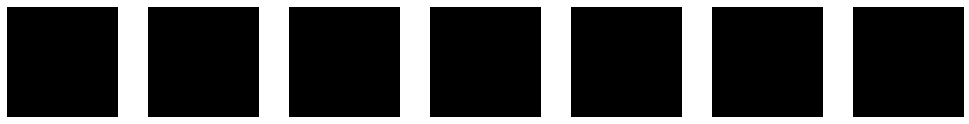

In [40]:
plot_image_with_seg(img_s[31:131, :, :] - img_a[55:155, :, :], orientation='Axial', num_subplots=7)

In [35]:
middle_z

105